In [1]:
import numpy as np     
import pandas as pd    
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load the dataset containing normalized text as well as the additional features obtained from notebook 1

df_train = pd.read_csv('Data\\disaster_tweets_kaggle\\train_clean_add_feat.csv', index_col = False)

df_train.head()

,text,target,text_norm,stemmed_keyword,disaster_asc_coeff,length_norm,neg,neu,pos
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquak may allah forgiv us,earthquak,0.785714,41,0.000,1.000,0.0
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la rong sask canada,fire,0.386364,36,0.286,0.714,0.0
2,All residents asked to 'shelter in place' are ...,1,resid ask shelter place notifi offic evacu she...,evacu,0.767241,69,0.000,1.000,0.0
3,"13,000 people receive #wildfires evacuation or...",1,13000 peopl receiv wildfir evacu order california,evacu,0.767241,49,0.000,1.000,0.0
4,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo rubi alaska smoke wildfir pour ...,fire,0.386364,52,0.000,1.000,0.0


In [3]:
# In this part we will compare results using the original text with minimum processing vs the normalized text 
df_orig = df_train[['text', 'target']]
df_norm = df_train[['text_norm', 'target']]

## 1) Training with Normalized Text Data
For this text data, stop words, symbols, urls and punctuations have been removed. In addition, the words have also been stemmed. This means that the vocabulariy will be smaller; however, any contextual information provided by stop words will be lost.

#### Prepare text data for embedding

In [4]:
# use tokenizer and padding to prepare data for embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
tokenizer = Tokenizer()

In [6]:
# fit text to data
tokenizer.fit_on_texts(df_norm['text_norm'])

In [7]:
# tokenize text data
df_tokens = tokenizer.texts_to_sequences(df_norm['text_norm'])
df_tokens[0]

[3855, 471, 218, 93, 1405, 3035, 18]

In [9]:
# get max length to pad sequences and abd vocab size
VOCAB_SIZE = len(tokenizer.word_index) + 1
MAX_LENGTH = max([len(text.split()) for text in df_norm['text_norm']])
# set embedding dimension to be 500
EMBEDDING_DIM = 500
print(f'Vocab size: {VOCAB_SIZE}')
print(f'Max sequence length: {MAX_LENGTH}')
print(f'Embedding dim: {EMBEDDING_DIM}')

Vocab size: 19542
Max sequence length: 25
Embedding dim: 500


In [10]:
# add padding
df_pad = pad_sequences(df_tokens, maxlen = MAX_LENGTH, padding = 'post')
df_pad[0]

array([3855,  471,  218,   93, 1405, 3035,   18,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0])

In [11]:
print(type(df_pad))
print(df_pad.shape)

<class 'numpy.ndarray'>
(7593, 25)


### Train Test Split

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X = df_pad
y = df_norm['target']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [16]:
X_train[0]

array([8122, 2736, 2331,  105, 1047,  834,  180,  111,  427, 8123, 8124,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0])

### Simple RNN model
Since the goal is to train a binary classification model, the RNN architecture will be many-to-one.

In [32]:
# basic architecture from tensorflow classiication with RNN documentation
import tensorflow as tf

In [33]:
model = tf.keras.Sequential()

The embedding layer converts the numeric representation of a word which would be a vector the length of the vocabularity if it were a dummy variable(with all entried 0's ecxept 1) and converts it to a vector of fixed length with all entries as floating point values. Therefore, instead of having a large sparse matrix for a sentence, we will have a smaller dense matrix as input. <br>
input_dim : Size of the vocabulary <br>
output_dim : Length of the embedded vector for each word <br>
input_length : Maximum length of a sequence

In [34]:
model.add(tf.keras.layers.Embedding(input_dim = VOCAB_SIZE,
        output_dim = EMBEDDING_DIM, input_length = MAX_LENGTH, mask_zero=True))
model.add(tf.keras.layers.LSTM(64, activation = 'tanh', dropout = 0.3))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(rate = 0.25))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1))

In [35]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 25, 300)           5862600   
                                                                 
 lstm_3 (LSTM)               (None, 64)                93440     
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 5,962,313
Trainable params: 5,962,313
No

In [36]:
# compile model
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              optimizer = tf.keras.optimizers.Adam(1e-4),
              metrics = ['accuracy'])

### Train Model

In [37]:
history = model.fit(X_train, y_train, batch_size = 32, epochs = 7,
                    validation_split = 0.25)

Epoch 1/15
120/120 [==============================] - 57s 350ms/step - loss: 0.6900 - accuracy: 0.5767 - val_loss: 0.6874 - val_accuracy: 0.5613
Epoch 2/15
120/120 [==============================] - 36s 302ms/step - loss: 0.6698 - accuracy: 0.5767 - val_loss: 0.6400 - val_accuracy: 0.5613
Epoch 3/15
120/120 [==============================] - 51s 427ms/step - loss: 0.5271 - accuracy: 0.6236 - val_loss: 0.5321 - val_accuracy: 0.7602
Epoch 4/15
120/120 [==============================] - 34s 281ms/step - loss: 0.3332 - accuracy: 0.8708 - val_loss: 0.5150 - val_accuracy: 0.7932
Epoch 5/15
120/120 [==============================] - 68s 571ms/step - loss: 0.2227 - accuracy: 0.9227 - val_loss: 0.5789 - val_accuracy: 0.7862
Epoch 6/15
120/120 [==============================] - 94s 779ms/step - loss: 0.1628 - accuracy: 0.9442 - val_loss: 0.6551 - val_accuracy: 0.7767
Epoch 7/15
120/120 [==============================] - 80s 673ms/step - loss: 0.1165 - accuracy: 0.9628 - val_loss: 0.7152 - val_ac

In [25]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 1.0887655226513744)

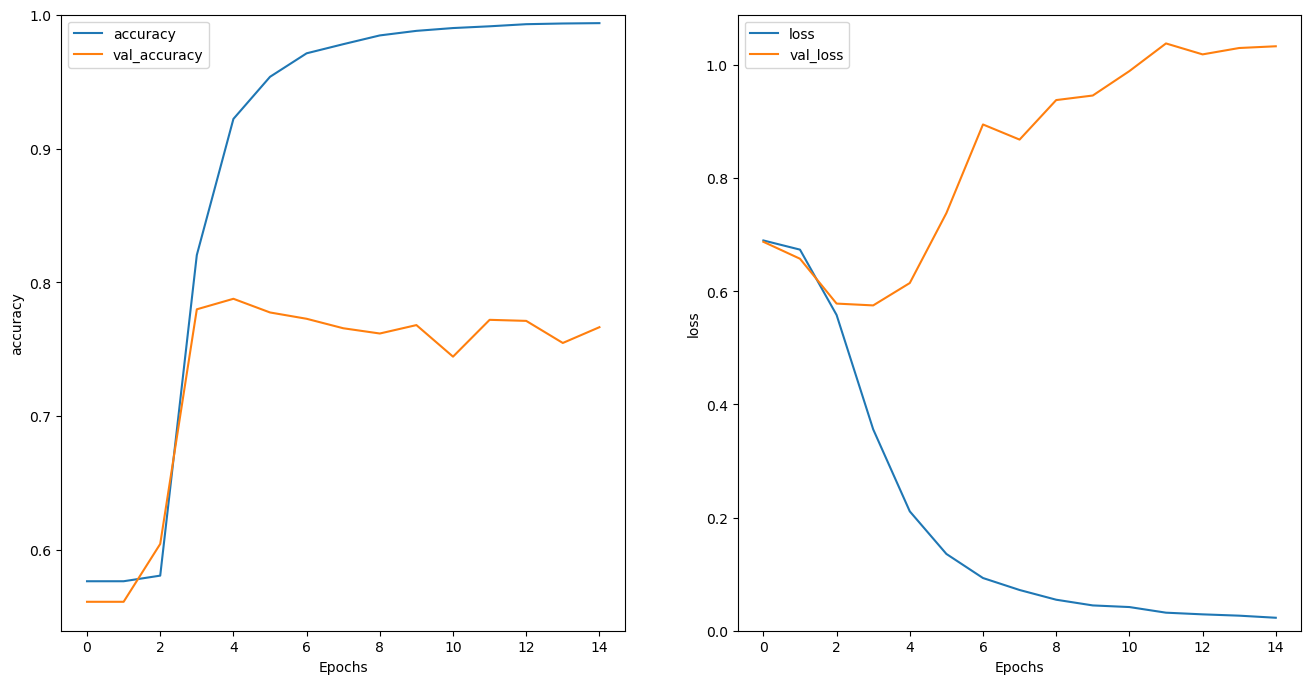

In [26]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [52]:
test_loss, test_acc = model.evaluate(X_test_pad, y_test)

79/79 [==============================] - 14s 171ms/step - loss: 1.1819 - accuracy: 0.7622


In [53]:
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

Test Loss: 1.1819095611572266
Test Accuracy: 0.7621707916259766
